# Use simple techniques for feature Engineering and to do multi-class classification to predict review ratings based on the Amazon Reviews dataset

Objective for this exercise:
    * Establish NLP prediction accuracy baseline using simple ML models
    * Explore different permutation of feature engineering techniques, data, and classification algorithms
    * Compare accuracy of preduction using the following information:
        * Product Title
        * Review Headline
        * Review Body
    * (If time allows) see if using only helpful reviews to train improves our accuracy for our predictions - this reduces our 110k dataset to 35k


Feature Engineering Techniques:
    * bag of words
    * TF-IDF
    
    
Classification:
    * Logistic Regression Classification
    * K-nearest Neighbors Classification
    
    
    
    
Data used in this notebooks has already been pre-processed in the previous notebook. For details, please see: [amazon_review_preprocessing.ipynb](amazon_review_preprocessing.ipynb)

```
python preprocess_amazon.py -l INFO -r -o dataset/amazon_reviews/amazon_reviews_us_Wireless_v1_00-smallout.csv dataset/amazon_reviews/amazon_reviews_us_Wireless_v1_00-smallin.csv
```

In [79]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta, datetime
import time


%matplotlib inline

In [111]:
# set global variables

# I'm finding that running these models on my laptop takes forever and they are not finishing so I'm going to start
# with a really small file just to validate my code
#
# datafile was generated from amazon_review_preprocessing.ipynb - this file has 1k reviews randomly chosen
# from original file
KEEP_COLUMNS = ["product_title", "helpful_votes", "review_headline", "review_body", "star_rating"]
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
OUTCOME_COLUMN = "star_rating"


# Configuration
DATA_FILE = "dataset/amazon_reviews/amazon_reviews_us_Wireless_v1_00-tinyout.csv"
NEIGHBORS = [5]
# NEIGHBORS = [1, 3, 5, 7, 9, 11]

# Radius for RadiusNeighbor
# didn't try too many numbers but tried 1 and 3 and didn't find any neighbors
RADII = [5.0]
# RADII = [5.0, 7.0, 9.0, 11.0, 13.0]
# logistic regression
C= [1.0]
# C = [0.2, 0.4, 0.6, 0.8, 1.0]
FEATURE_COLUMN = "review_headline"
ENABLE_KNN = True
ENABLE_RN = True
ENABLE_LR = True



In [ ]:
# read in DF
df = pd.read_csv(DATA_FILE)[KEEP_COLUMNS]
print(df.info())
df.head()

In [3]:
# let's get some data on our text

def wc(x:str):
    return len(str(x).split())

df["pt_wc"] = df.product_title.apply(wc)
df["rh_wc"] = df.review_headline.apply(wc)
df["rb_wc"] = df.review_body.apply(wc)
df.describe()

,helpful_votes,star_rating,pt_wc,rh_wc,rb_wc
count,22414.000000,22414.000000,22414.000000,22414.000000,22414.000000
mean,0.904792,3.895333,15.907335,2.956322,25.979700
std,8.709008,1.465474,9.716846,1.915684,41.441713
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,3.000000,9.000000,2.000000,8.000000
50%,0.000000,5.000000,14.000000,2.000000,15.000000
75%,0.000000,5.000000,20.000000,4.000000,28.000000
max,868.000000,5.000000,92.000000,21.000000,1133.000000


In [4]:
# Set up different dataframes for training

# outcome
Y = df["star_rating"]
X = df[FEATURE_COLUMN]

# Bag of Words

In [5]:
# TODO: try different parameters for CountVectorizers?
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(X.array)
vocab = cv.get_feature_names()
# print(f"vocab: {vocab}")
bag_pd = pd.DataFrame(cv_matrix.toarray(), columns=vocab)

In [6]:
# explore the data
print(len(vocab))
bag_pd.head()

5646


,00,000,02,03,04,05,06,07,09,0s,...,zero,zerolemon,zgreat,zip,zippers,zone,zoom,zr,zte,zune
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# split results into training and test set
bag_X_train, bag_X_test, bag_Y_train, bag_Y_test = train_test_split(bag_pd, Y, random_state=1)

print(f"training set size {len(bag_X_train)}")
print(f"test set size {len(bag_X_test)}")

training set size 16810
training set size 5604


### Define a function to help us run models

In [98]:
def run_model(model, X_train, Y_train, X_test, Y_test):
        """
        model: model to train with
        X_test: training input
        Y_train: training classes
        X_test: test input
        Y_test: result
        -----
        return dictionary with train time, score time, total time, score
        """

        train_time_start = datetime.now()
        print(f'Start training: {train_time_start.strftime(TIME_FORMAT)}')
        result = model.fit(bag_X_train, bag_Y_train)

        train_time_end = datetime.now()
        print(f'End training: {train_time_end.strftime(TIME_FORMAT)}')

        score = result.score(bag_X_test, bag_Y_test)

        score_time_end = datetime.now()
        print(f'End Scoring: {score_time_end.strftime(TIME_FORMAT)}')

        train_time = train_time_end - train_time_start
        train_time_min = round(time_diff.total_seconds() / 60)
        print(f'Training time (min): {train_time_min}')


        score_time = score_time_end - train_time_end
        score_time_min = round(score_time.total_seconds() / 60)
        print(f'Scoring time (min): {score_time_min}')

        print(f'Training score: {score}')

        return {
                "train_time_min": train_time_min,
                "score_time_min": score_time_min,
                "total_time_min": train_time_min + score_time_min,
                "score": score
               }



### Bag of Words Using KNN

In [46]:
# # use K-nearest neighbors to train

# knn_results_pd = pd.DataFrame()

# # TODO: Use GridCV to test different parameters for n_neighbors
# if ENABLE_KNN:
#     for neighbor in NEIGHBORS:
#         neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
        
#         train_time_start = datetime.now()
#         print(f'Start training: {train_time_start.strftime(TIME_FORMAT)}')
#         neigh.fit(bag_X_train, bag_Y_train)

#         train_time_end = datetime.now()
#         print(f'End training: {train_time_end.strftime(TIME_FORMAT)}')
#         score = neigh.score(bag_X_test, bag_Y_test)

#         score_time_end = datetime.now()
#         print(f'End Scoring: {score_time_end.strftime(TIME_FORMAT)}')

#         train_time = train_time_end - train_time_start
#         train_time_min = round(time_diff.total_seconds() / 60)
#         print(f'Training time (min): {train_time_min}')

#         score_time = score_time_end - train_time_end
#         score_time_min = round(score_time.total_seconds() / 60)
#         print(f'Scoring time (min): {score_time_min}')

#         print(f'Training score: {score}')

#         knn_results_pd = knn_results_pd.append({
#                         "neighbors": neighbor,
#                         "train_time_min": train_time_min,
#                         "score_time_min": score_time_min,
#                         "total_time_min": train_time_min + score_time_min,
#                         "score": score
#                        }, ignore_index=True)

    

# knn_results_pd.head()

Start training: 2019-05-16 00:15:13
End training: 2019-05-16 00:15:19
End Scoring: 2019-05-16 00:17:39
Training time (min): 8
Scoring time (min): 2
Training score: 0.6598857958600999


In [109]:
# use K-nearest neighbors to train
knn_results_pd = pd.DataFrame(columns=["neighbors", "train_time_min", "score_time_min", "total_time_min", "score"])

if ENABLE_KNN:

    for neighbor in NEIGHBORS:
        print(f'{neighbor} neighbors\n-----------------------')
        neigh = KNeighborsClassifier(n_neighbors=neighbor, n_jobs=-1)
        results = run_model(neigh, bag_X_train, bag_Y_train, bag_X_test, bag_Y_test)
        results["neighbors"] = neighbor
        knn_results_pd = knn_results_pd.append(results, ignore_index=True)

knn_results_pd.head()
        


5 neighbors
-----------------------
Start training: 2019-05-16 01:51:16
End training: 2019-05-16 01:51:23
End Scoring: 2019-05-16 01:54:07
Training time (min): 8
Scoring time (min): 3
Training score: 0.6598857958600999


,neighbors,train_time_min,score_time_min,total_time_min,score
0,5.0,8.0,3.0,11.0,0.659886


In [61]:
# # visualize some data
# # score by neighbor
# # total time by neighbor
# columns=["neighbors", "score_time_min", "total_time_min", "score"]

# knn_results_pd = pd.DataFrame()
# knn_results_pd = knn_results_pd.append({"neighbors": neighbor,
#                         "train_time_min": train_time_min,
#                         "score_time_min": score_time_min,
#                         "total_time_min": train_time_min + score_time_min,
#                         "score": score
#                        }, ignore_index=True)
# knn_results_pd = knn_results_pd.append({"neighbors": 1,
#                         "train_time_min": 1,
#                         "score_time_min": 3,
#                         "total_time_min": 1 + 3,
#                         "score": 0.55
#                        }, ignore_index=True)
# knn_results_pd.head()



,neighbors,score,score_time_min,total_time_min,train_time_min
0,5.0,0.659886,2.0,10.0,8.0
1,1.0,0.550000,3.0,4.0,1.0


### Bag of Words using Radius Neighbors Classifier

Documentation says if the data is not evenly distributed Radius Neighbors might be a better algorithm so trying that here

In [77]:
# rn_results_pd = pd.DataFrame()

# RADII = [5.0]

# # TODO: Use GridCV to test different parameters for n_neighbors
# if ENABLE_RN:
#     for radius in RADII:
#         neigh = RadiusNeighborsClassifier(radius=radius, n_jobs=-1)
        
#         train_time_start = datetime.now()
#         print(f'Start training: {train_time_start.strftime(TIME_FORMAT)}')
#         neigh.fit(bag_X_train, bag_Y_train)

#         train_time_end = datetime.now()
#         print(f'End training: {train_time_end.strftime(TIME_FORMAT)}')
#         score = neigh.score(bag_X_test, bag_Y_test)

#         score_time_end = datetime.now()
#         print(f'End Scoring: {score_time_end.strftime(TIME_FORMAT)}')

#         train_time = train_time_end - train_time_start
#         train_time_min = round(time_diff.total_seconds() / 60)
#         print(f'Training time (min): {train_time_min}')

#         score_time = score_time_end - train_time_end
#         score_time_min = round(score_time.total_seconds() / 60)
#         print(f'Scoring time (min): {score_time_min}')

#         print(f'Training score: {score}')

#         rn_results_pd = rn_results_pd.append({
#                         "radius": radius,
#                         "train_time_min": train_time_min,
#                         "score_time_min": score_time_min,
#                         "total_time_min": train_time_min + score_time_min,
#                         "score": score
#                        }, ignore_index=True)

    

# rn_results_pd.head()

Start training: 2019-05-16 01:06:03
End training: 2019-05-16 01:06:10
End Scoring: 2019-05-16 01:09:33
Training time (min): 8
Scoring time (min): 3
Training score: 0.543718772305496


,radius,score,score_time_min,total_time_min,train_time_min
0,5.0,0.543719,3.0,11.0,8.0


In [110]:
rn_results_pd = pd.DataFrame()

if ENABLE_RN:
    for radius in RADII:
        rnc = RadiusNeighborsClassifier(radius=radius, n_jobs=-1)
        print(f'Radius: {radius}\n-----------------------')
        results = run_model(rnc, bag_X_train, bag_Y_train, bag_X_test, bag_Y_test)
        results["radius"] = radius
        rn_results_pd = rn_results_pd.append(results, ignore_index=True)

rn_results_pd.head()


Radius: 5.0
-----------------------
Start training: 2019-05-16 01:55:34
End training: 2019-05-16 01:55:42
End Scoring: 2019-05-16 02:00:07
Training time (min): 8
Scoring time (min): 4
Training score: 0.543718772305496


,radius,score,score_time_min,total_time_min,train_time_min
0,5.0,0.543719,4.0,12.0,8.0


### Bag of Word using Logistic Regression - what parameters should I play with here?

In [82]:
# # Let's try Logistic Regresion
# lr_results_pd = pd.DataFrame()

# C = [1.0]
# if ENABLE_LR:
#     for c in C:
#         train_time_start = datetime.now()
#         print(f'Start training: {train_time_start.strftime(TIME_FORMAT)}')
#         clf = LogisticRegression(random_state=0, solver='lbfgs',
#                                   multi_class='auto',
#                                 max_iter=1000, n_jobs=-1).fit(bag_X_train, bag_Y_train)
        
#         train_time_end = datetime.now()
#         print(f'End training: {train_time_end.strftime(TIME_FORMAT)}')
        
#         score = neigh.score(bag_X_test, bag_Y_test)

#         score_time_end = datetime.now()
#         print(f'End Scoring: {score_time_end.strftime(TIME_FORMAT)}')
        
#         train_time = train_time_end - train_time_start
#         train_time_min = round(time_diff.total_seconds() / 60)
#         print(f'Training time (min): {train_time_min}')

        
#         score_time = score_time_end - train_time_end
#         score_time_min = round(score_time.total_seconds() / 60)
#         print(f'Scoring time (min): {score_time_min}')

#         print(f'Training score: {score}')

#         lr_results_pd = lr_results_pd.append({
#                         "c": c,
#                         "train_time_min": train_time_min,
#                         "score_time_min": score_time_min,
#                         "total_time_min": train_time_min + score_time_min,
#                         "score": score
#                        }, ignore_index=True)

# lr_results_pd.head()

Start training: 2019-05-16 01:17:12
End training: 2019-05-16 01:21:25
End Scoring: 2019-05-16 01:24:46
Training time (min): 8
Scoring time (min): 3
Training score: 0.543718772305496


,c,score,score_time_min,total_time_min,train_time_min
0,1.0,0.543719,3.0,11.0,8.0


In [ ]:
lr_results_pd = pd.DataFrame()

if ENABLE_LR:
    for c in C:
        lr = LogisticRegression(random_state=0, solver='lbfgs',
                                  multi_class='auto',
                                max_iter=1000, n_jobs=-1)
        print(f'Radius: {radius}\n-----------------------')
        results = run_model(lr, bag_X_train, bag_Y_train, bag_X_test, bag_Y_test)
        results["c"] = c
        lr_results_pd = lr_results_pd.append(results, ignore_index=True)

lr_results_pd.head()


Radius: 5.0
-----------------------
Start training: 2019-05-16 02:02:19


# TD-IDF

In [92]:
# TODO: play with min_df and max_df
# TODO: play with variations of ngram
tv = TfidfVectorizer(min_df=0., max_df=1., ngram_range=(1,3), use_idf=True)
tv_matrix = tv.fit_transform(X.array)
vocab = tv.get_feature_names()
tv_pd = pd.DataFrame(np.round(tv_matrix.toarray(), 2), columns=vocab)

In [ ]:
# split results into training and test set
tv_X_train, tv_X_test, tv_Y_train, tv_Y_test = train_test_split(tv_pd, Y, random_state=1)

print(f"training set size {len(tv_X_train)}")
print(f"test set size {len(tv_X_test)}")

### KNN

In [ ]:
# use K-nearest neighbors to train
knn_tv_results_pd = pd.DataFrame(columns=["neighbors", "train_time_min", "score_time_min", "total_time_min", "score"])

if ENABLE_KNN:

    for neighbor in NEIGHBORS:
        print(f'{neighbor} neighbors\n-----------------------')
        neigh = KNeighborsClassifier(n_neighbors=neighbor, n_jobs=-1)
        results = run_model(neigh, tv_X_train, tv_Y_train, tv_X_test, tv_Y_test)
        results["neighbors"] = neighbor
        knn_tv_results_pd = knn_tv_results_pd.append(results, ignore_index=True)

knn_tv_results_pd.head()
        


### Radius Neighbor Classifier

In [ ]:
rn_tv_results_pd = pd.DataFrame()

if ENABLE_RN:
    for radius in RADII:
        rnc = RadiusNeighborsClassifier(radius=radius, n_jobs=-1)
        print(f'Radius: {radius}\n-----------------------')
        results = run_model(rnc, tv_X_train, tv_Y_train, tv_X_test, tv_Y_test)
        results["radius"] = radius
        rn_tv_results_pd = rn_tv_results_pd.append(results, ignore_index=True)

rn_tv_results_pd.head()


### Logistic Regression Classifier

In [ ]:
lr_tv_results_pd = pd.DataFrame()

if ENABLE_LR:
    for c in C:
        lr = LogisticRegression(random_state=0, solver='lbfgs',
                                  multi_class='auto',
                                max_iter=1000, n_jobs=-1)
        print(f'Radius: {radius}\n-----------------------')
        results = run_model(lr, tv_X_train, tv_Y_train, tv_X_test, tv_Y_test)
        results["c"] = c
        lr_tv_results_pd = lr_tv_results_pd.append(results, ignore_index=True)

lr_tv_results_pd.head()


Text(0.5, 1.0, 'Logistic Regression Score')

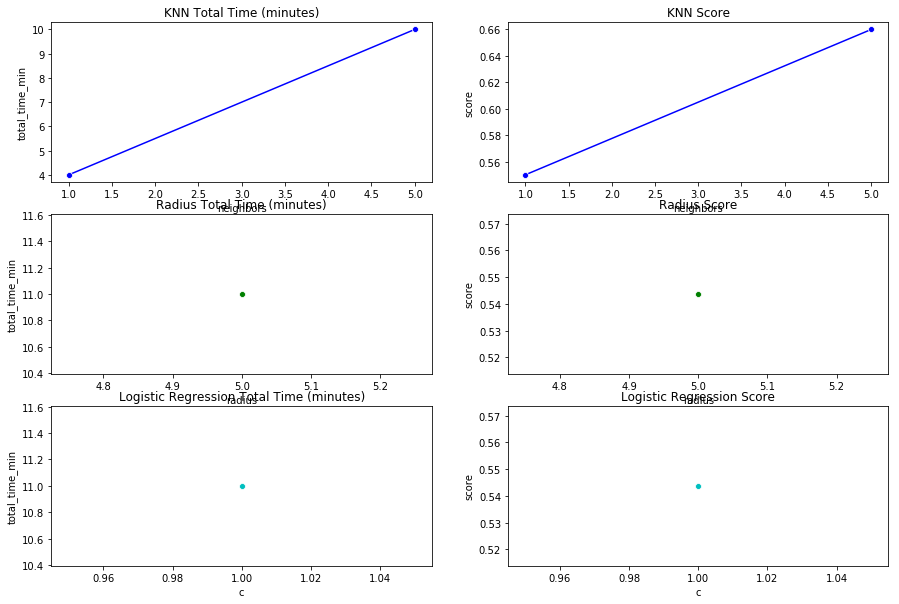

In [88]:
# visualize some data

f, ax = plt.subplots(3, 2, figsize=(15,10))
plt.tight_layout(pad=2)

# total time by neighbor
sns.lineplot(x="neighbors", y="total_time_min", data=knn_results_pd, marker='o', color='b', ax=ax[0, 0])
ax[0, 0].set_title("KNN Total Time (minutes)")

# score by neighbor
sns.lineplot(x="neighbors", y="score", data=knn_results_pd, marker='o', color='b', ax=ax[0, 1])
ax[0, 1].set_title("KNN Score")


# total time by radius
sns.lineplot(x="radius", y="total_time_min", data=rn_results_pd, marker='o', color='g', ax=ax[1, 0])
ax[1, 0].set_title("Radius Total Time (minutes)")

# score by neighbor
sns.lineplot(x="radius", y="score", data=rn_results_pd, marker='o', color='g', ax=ax[1, 1])
ax[1, 1].set_title("Radius Score")

# total time by radius
sns.lineplot(x="c", y="total_time_min", data=lr_results_pd, marker='o', color='c', ax=ax[2, 0])
ax[2, 0].set_title("Logistic Regression Total Time (minutes)")

# score by neighbor
sns.lineplot(x="c", y="score", data=lr_results_pd, marker='o', color='c', ax=ax[2, 1])
ax[2, 1].set_title("Logistic Regression Score")


# TF-IDF

In [93]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(X.array)
vocab = tv.get_feature_names()
tv_pd = pd.DataFrame(np.round(tv_matrix.toarray(), 2), columns=vocab)

In [94]:
# explore the data
print(len(vocab))
tv_pd.head()

5646


,00,000,02,03,04,05,06,07,09,0s,...,zero,zerolemon,zgreat,zip,zippers,zone,zoom,zr,zte,zune
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# split results into training and test set
tfidf_X_train, tfidf_X_test, tfidf_Y_train, tfidf_Y_test = train_test_split(tv_pd, Y, random_state=1)

print(f"training set size {len(tfidf_X_train)}")
print(f"test set size {len(tfidf_X_test)}")

training set size 16810
test set size 5604
